In [1]:
import random 
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display
from itertools import combinations, groupby
import grinpy as gp

In [24]:
def draw(G, node_color, edge_color, pos):
    node_lab = {i for i in G.nodes()}
    plt.figure(figsize=(4,4))
    nx.draw(G, pos, with_labels=True, node_color=node_color, edge_color=edge_color, node_size=500)
    plt.show()

def draw_sol(G, color_map, pos, edge_color='black'):
    node_lab = {i for i in G.nodes()}
    plt.figure(figsize=(4,4))
    nx.draw(G, pos, with_labels=True, node_color=color_map, edge_color=edge_color, node_size=500)
    plt.show()

# **Q1**
Give 2 examples of graphs of order a least 6 for which we have z(G, χ(G)) = 0. That is one can find a coloring π using k = χ(G) colors and such that B(G, π) = 0. Recall that χ(G) is the minimum number of colors needed to color the vertices of G.

![alt text](a.jpg "Title")

# **Q2**

Give 2 examples of graphs of order a least 5 for which we have z(G, χ(G)) > 0.

![alt text](b.jpg "Title")

# **Q3**
Write a ILP that, given a graph G = (V, E) and a number k of colors, finds z(G, k). That is, the ILP finds a coloring π of the vertices that uses k colors and such that B(G, π) is minimized.
You must ensure that the k colors are used.

![alt text](c.jpg "Title")

# **Q4**
Implement the ILP and find the value of z(G, k) for k in range from χ(G) to n when the graph G is a square grid of side 3, a square grid of side 4 and the Petersen Graph.

## **Q4** - Balanced Coloring ILP model

In [25]:
## Inside this function the ILP model for the problem is built, runned and the solution is drawn
def balance_coloring_solver(G, k_size):
    
    C = [k for k in range(k_size)]
    # Build our Model
    balanced_coloring = gb.Model()

    # add Variables
    x = balanced_coloring.addVars(G.nodes(), C, vtype=gb.GRB.BINARY, name='x')
    alpha = balanced_coloring.addVar(vtype=gb.GRB.CONTINUOUS, ub=len(G.nodes()), name='alpha')
    beta = balanced_coloring.addVar(vtype=gb.GRB.CONTINUOUS, lb=0, name='beta')

    # add Objective
    balanced_coloring.setObjective(alpha-beta, gb.GRB.MINIMIZE)

    balanced_coloring.addConstr(k_size<=len(G.nodes()))

    # Constraints
    for c in C:
        # alpha-beta constraints
        balanced_coloring.addConstr(alpha >= gb.quicksum(x[i,c] for i in G.nodes()), 'max_alpha_'+str(c))
        balanced_coloring.addConstr(beta <= gb.quicksum(x[i,c] for i in G.nodes()), 'min_beta_'+str(c))

        # coloring constraints
        for i,j in G.edges():
            balanced_coloring.addConstr(x[i,c] + x[j,c] <= 1, 'coloring_'+str(c)+'_('+str(i)+','+str(j)+')')

        # color usage constraints
        balanced_coloring.addConstr(gb.quicksum(x[i,c] for i in G.nodes())>=1, 'color_usage'+str(c))

    for i in G.nodes():
        balanced_coloring.addConstr(gb.quicksum(x[i,c] for c in C) == 1, 'one_color_'+str(i))

    balanced_coloring.update()
    
    ## solve the problem
    balanced_coloring.optimize()
    
    print("The optimal value is ", balanced_coloring.objVal)
    
    # draw the solution 
    color_map = []
    palette = ['#%06X' % random.randint(0, 0xFFFFFF) for i in G.nodes()]
    for i in G.nodes():
        for c in range(k_size):
            if(x[i,c].x > 1E-3):
                color_map.append(palette[c])
    return color_map, balanced_coloring.objVal

## **Q4** - 3 sided square grid 

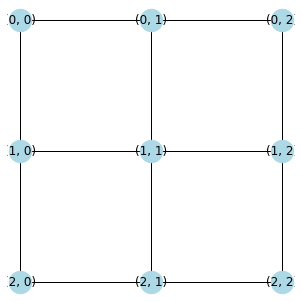

=================================================================  k size 2 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 40 rows, 20 columns and 124 nonzeros
Model fingerprint: 0x2d99e382
Variable types: 2 continuous, 18 integer (18 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 40 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
The optimal value is  1.

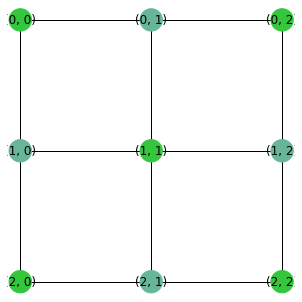

=================================================================  k size 3 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 55 rows, 29 columns and 186 nonzeros
Model fingerprint: 0x3fafcd95
Variable types: 2 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 54 rows, 29 columns, 186 nonzeros
Variable types: 0 continuous, 29 integer (27 binary)

Root relaxation: objective 0.000000e+00, 26 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node T

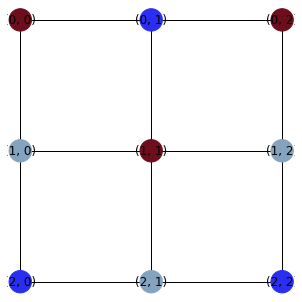

=================================================================  k size 4 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 70 rows, 38 columns and 248 nonzeros
Model fingerprint: 0x84fa0d45
Variable types: 2 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 69 rows, 38 columns, 248 nonzeros
Variable types: 0 continuous, 38 integer (36 binary)

Root relaxation: objective 0.000000e+00, 29 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node T

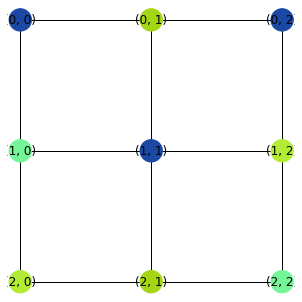

=================================================================  k size 5 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 85 rows, 47 columns and 310 nonzeros
Model fingerprint: 0x57cbcf9d
Variable types: 2 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 84 rows, 47 columns, 310 nonzeros
Variable types: 0 continuous, 47 integer (45 binary)

Root relaxation: objective 0.000000e+00, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node T

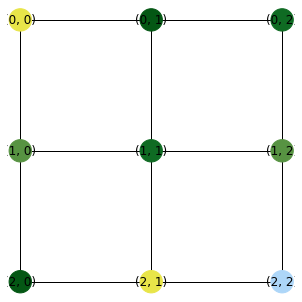

=================================================================  k size 6 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 100 rows, 56 columns and 372 nonzeros
Model fingerprint: 0xd7f8d38d
Variable types: 2 continuous, 54 integer (54 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 99 rows, 56 columns, 372 nonzeros
Variable types: 0 continuous, 56 integer (54 binary)

Root relaxation: objective 0.000000e+00, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node 

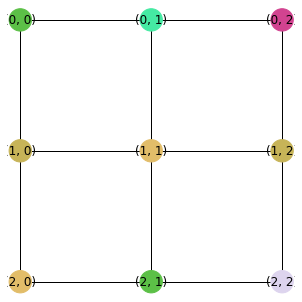

=================================================================  k size 7 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 115 rows, 65 columns and 434 nonzeros
Model fingerprint: 0x8e82c5ba
Variable types: 2 continuous, 63 integer (63 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 114 rows, 65 columns, 434 nonzeros
Variable types: 0 continuous, 65 integer (63 binary)

Root relaxation: objective -2.220446e-16, 48 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

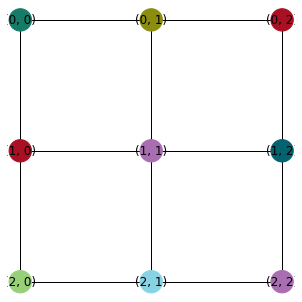

=================================================================  k size 8 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 130 rows, 74 columns and 496 nonzeros
Model fingerprint: 0xbcf6eea2
Variable types: 2 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 129 rows, 74 columns, 496 nonzeros
Variable types: 0 continuous, 74 integer (72 binary)

Root relaxation: objective 0.000000e+00, 45 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

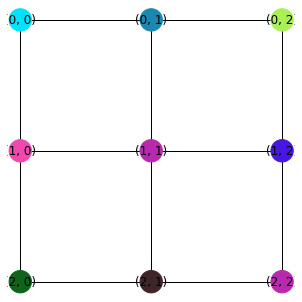

In [26]:
grid_dim = [3,3]

G = nx.grid_graph(dim=grid_dim, periodic=False)

pos = {(x,y):(y,-x) for x,y in G.nodes()}
draw(G, "lightblue", "black", pos)

original_mapping = {}
mapping = {}
i = 0
for node in G.nodes():
    mapping[node] = i
    original_mapping[i] = node
    i+=1

solutions_3grid = {}
## solve the problem for the 3-sided grid, and for each k ranging from the chromatich number to n
for k_size in range(gp.chromatic_number(G), len(G.nodes)):
    print((' \033[1m' + " k size "+str(k_size) + '\033[0m ').center(150, '='))
    G = nx.relabel_nodes(G, mapping)

    color_map, sol_val = balance_coloring_solver(G, k_size)
    G = nx.relabel_nodes(G, original_mapping)
    draw_sol(G, color_map, pos)
    solutions_3grid[k_size] = sol_val

In [27]:
for k in solutions_3grid:
    print("k", k, " -> sol", solutions_3grid[k]) #for each k contains the value of the z(G, k)

k 2  -> sol 1.0
k 3  -> sol 0.0
k 4  -> sol 1.0
k 5  -> sol 1.0
k 6  -> sol 1.0
k 7  -> sol 1.0
k 8  -> sol 1.0


## **Q4** - 4 sided square grid

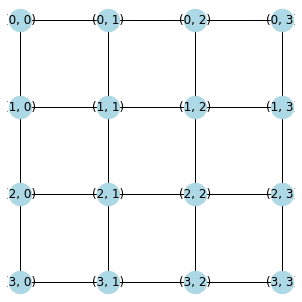

=================================================================  k size 2 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 71 rows, 34 columns and 228 nonzeros
Model fingerprint: 0x334bd5bb
Variable types: 2 continuous, 32 integer (32 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000
Presolve removed 71 rows and 34 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
The optimal value is  0.

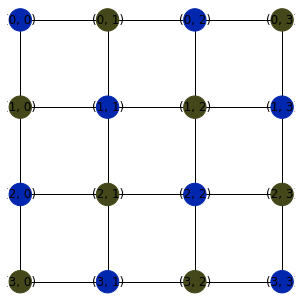

=================================================================  k size 3 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 98 rows, 50 columns and 342 nonzeros
Model fingerprint: 0x9076865a
Variable types: 2 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 97 rows, 50 columns, 342 nonzeros
Variable types: 0 continuous, 50 integer (48 binary)

Root relaxation: objective 8.881784e-16, 41 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node T

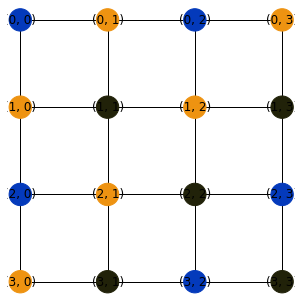

=================================================================  k size 4 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 125 rows, 66 columns and 456 nonzeros
Model fingerprint: 0x2b128d24
Variable types: 2 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 124 rows, 66 columns, 456 nonzeros
Variable types: 0 continuous, 66 integer (64 binary)

Root relaxation: objective 0.000000e+00, 36 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

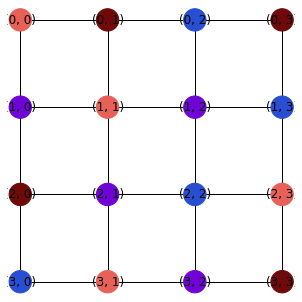

=================================================================  k size 5 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 152 rows, 82 columns and 570 nonzeros
Model fingerprint: 0xbeed0797
Variable types: 2 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 151 rows, 82 columns, 570 nonzeros
Variable types: 0 continuous, 82 integer (80 binary)

Root relaxation: objective 0.000000e+00, 56 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

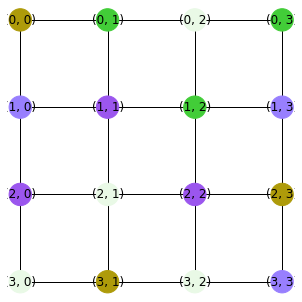

=================================================================  k size 6 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 179 rows, 98 columns and 684 nonzeros
Model fingerprint: 0x8a4f8b6e
Variable types: 2 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 178 rows, 98 columns, 684 nonzeros
Variable types: 0 continuous, 98 integer (96 binary)

Root relaxation: objective -8.881784e-16, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

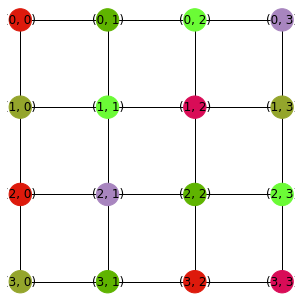

=================================================================  k size 7 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 206 rows, 114 columns and 798 nonzeros
Model fingerprint: 0x9e461f11
Variable types: 2 continuous, 112 integer (112 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 205 rows, 114 columns, 798 nonzeros
Variable types: 0 continuous, 114 integer (112 binary)

Root relaxation: objective 8.881784e-16, 54 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

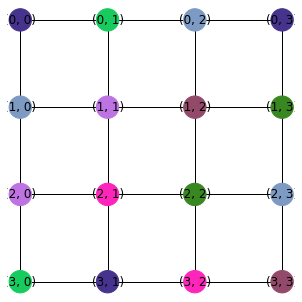

=================================================================  k size 8 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 233 rows, 130 columns and 912 nonzeros
Model fingerprint: 0xfb26a578
Variable types: 2 continuous, 128 integer (128 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 232 rows, 130 columns, 912 nonzeros
Variable types: 0 continuous, 130 integer (128 binary)

Root relaxation: objective 0.000000e+00, 63 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

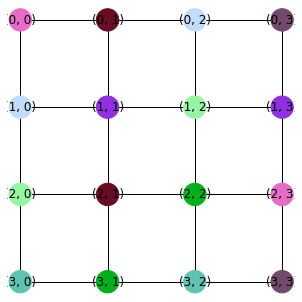

=================================================================  k size 9 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 260 rows, 146 columns and 1026 nonzeros
Model fingerprint: 0x0580b89b
Variable types: 2 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 259 rows, 146 columns, 1026 nonzeros
Variable types: 0 continuous, 146 integer (144 binary)

Root relaxation: objective 0.000000e+00, 78 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

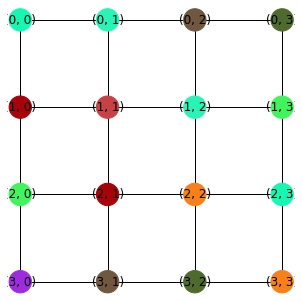

=================================================================  k size 10 =================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 287 rows, 162 columns and 1140 nonzeros
Model fingerprint: 0xe4f4ec82
Variable types: 2 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 286 rows, 162 columns, 1140 nonzeros
Variable types: 0 continuous, 162 integer (160 binary)

Root relaxation: objective -1.110223e-15, 93 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap 

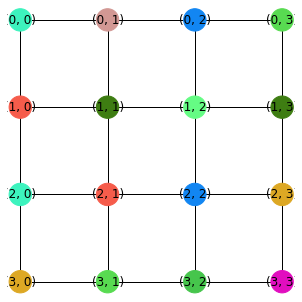

=================================================================  k size 11 =================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 314 rows, 178 columns and 1254 nonzeros
Model fingerprint: 0x6724a837
Variable types: 2 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 313 rows, 178 columns, 1254 nonzeros
Variable types: 0 continuous, 178 integer (176 binary)

Root relaxation: objective 0.000000e+00, 102 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap 

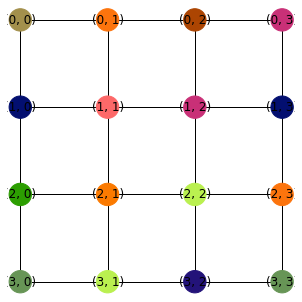

=================================================================  k size 12 =================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 341 rows, 194 columns and 1368 nonzeros
Model fingerprint: 0x52a297c1
Variable types: 2 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 340 rows, 194 columns, 1368 nonzeros
Variable types: 0 continuous, 194 integer (192 binary)

Root relaxation: objective 0.000000e+00, 93 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

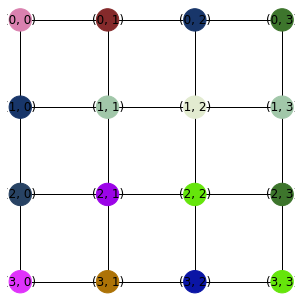

=================================================================  k size 13 =================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 368 rows, 210 columns and 1482 nonzeros
Model fingerprint: 0x3e43cdc3
Variable types: 2 continuous, 208 integer (208 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 367 rows, 210 columns, 1482 nonzeros
Variable types: 0 continuous, 210 integer (208 binary)

Root relaxation: objective -6.661338e-16, 100 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap

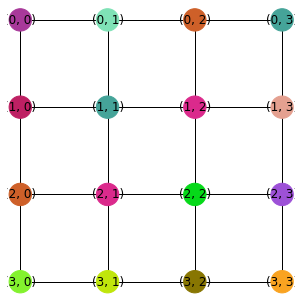

=================================================================  k size 14 =================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 395 rows, 226 columns and 1596 nonzeros
Model fingerprint: 0x8c3e770a
Variable types: 2 continuous, 224 integer (224 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 394 rows, 226 columns, 1596 nonzeros
Variable types: 0 continuous, 226 integer (224 binary)

Root relaxation: objective 0.000000e+00, 103 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap 

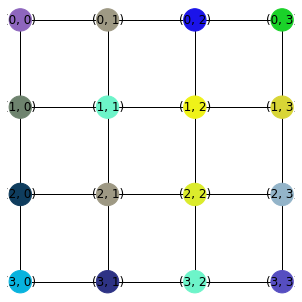

=================================================================  k size 15 =================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 422 rows, 242 columns and 1710 nonzeros
Model fingerprint: 0x870fd71f
Variable types: 2 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 421 rows, 242 columns, 1710 nonzeros
Variable types: 0 continuous, 242 integer (240 binary)

Root relaxation: objective 4.440892e-16, 126 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap 

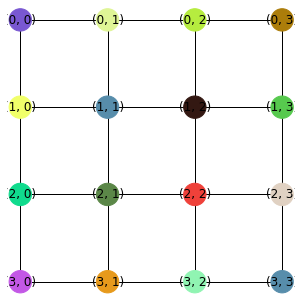

In [28]:
grid_dim = [4,4]

G = nx.grid_graph(dim=grid_dim, periodic=False)

pos = {(x,y):(y,-x) for x,y in G.nodes()}
draw(G, "lightblue", "black", pos)

original_mapping = {}
mapping = {}
i = 0
for node in G.nodes():
    mapping[node] = i
    original_mapping[i] = node
    i+=1

solutions_4grid = {}
## solve the problem for the 4-sided grid, and for each k ranging from the chromatich number to n
for k_size in range(gp.chromatic_number(G), len(G.nodes)):
    print((' \033[1m' + " k size "+str(k_size) + '\033[0m ').center(150, '='))
    G = nx.relabel_nodes(G, mapping)

    color_map, sol = balance_coloring_solver(G, k_size)
    G = nx.relabel_nodes(G, original_mapping)
    
    draw_sol(G, color_map, pos)
    solutions_4grid[k_size] = sol

In [29]:
for k in solutions_4grid:
    print("k", k, " -> sol", solutions_4grid[k]) #for each k contains the value of the z(G, k)

k 2  -> sol 0.0
k 3  -> sol 1.0
k 4  -> sol 0.0
k 5  -> sol 1.0
k 6  -> sol 1.0
k 7  -> sol 1.0
k 8  -> sol 0.0
k 9  -> sol 1.0
k 10  -> sol 1.0
k 11  -> sol 1.0
k 12  -> sol 1.0
k 13  -> sol 1.0
k 14  -> sol 1.0
k 15  -> sol 1.0


## **Q4** - Petersen Graph

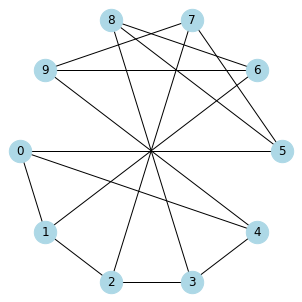

=================================================================  k size 3 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 65 rows, 32 columns and 216 nonzeros
Model fingerprint: 0x98fba316
Variable types: 2 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 64 rows, 32 columns, 216 nonzeros
Variable types: 0 continuous, 32 integer (30 binary)

Root relaxation: objective -4.440892e-16, 38 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node 

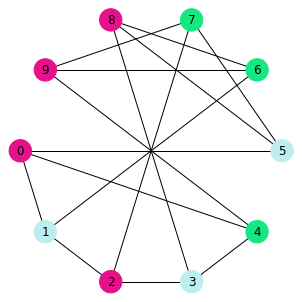

=================================================================  k size 4 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 83 rows, 42 columns and 288 nonzeros
Model fingerprint: 0x8eb61e30
Variable types: 2 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 82 rows, 42 columns, 288 nonzeros
Variable types: 0 continuous, 42 integer (40 binary)

Root relaxation: objective 0.000000e+00, 37 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node T

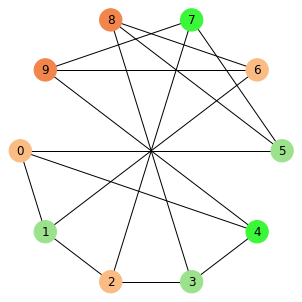

=================================================================  k size 5 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 101 rows, 52 columns and 360 nonzeros
Model fingerprint: 0x23a1d41d
Variable types: 2 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 52 columns, 360 nonzeros
Variable types: 0 continuous, 52 integer (50 binary)

Root relaxation: objective 0.000000e+00, 35 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

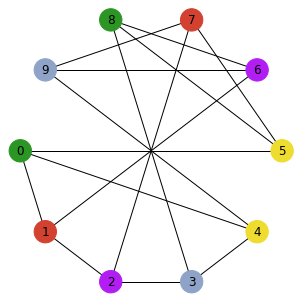

=================================================================  k size 6 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 119 rows, 62 columns and 432 nonzeros
Model fingerprint: 0xf88f395f
Variable types: 2 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 118 rows, 62 columns, 432 nonzeros
Variable types: 0 continuous, 62 integer (60 binary)

Root relaxation: objective 0.000000e+00, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

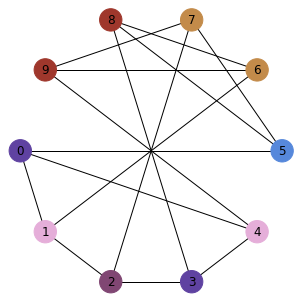

=================================================================  k size 7 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 137 rows, 72 columns and 504 nonzeros
Model fingerprint: 0x82d793d6
Variable types: 2 continuous, 70 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 136 rows, 72 columns, 504 nonzeros
Variable types: 0 continuous, 72 integer (70 binary)

Root relaxation: objective 0.000000e+00, 52 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

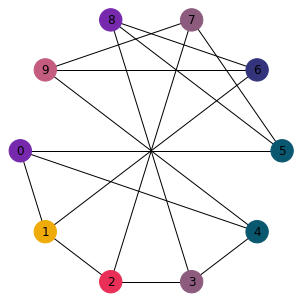

=================================================================  k size 8 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 155 rows, 82 columns and 576 nonzeros
Model fingerprint: 0x92944ee7
Variable types: 2 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 154 rows, 82 columns, 576 nonzeros
Variable types: 0 continuous, 82 integer (80 binary)

Root relaxation: objective 0.000000e+00, 55 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

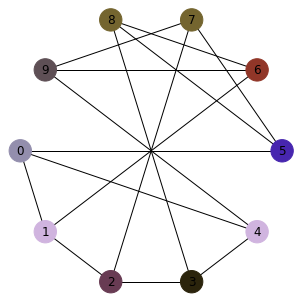

=================================================================  k size 9 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 173 rows, 92 columns and 648 nonzeros
Model fingerprint: 0xa4b68da5
Variable types: 2 continuous, 90 integer (90 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 172 rows, 92 columns, 648 nonzeros
Variable types: 0 continuous, 92 integer (90 binary)

Root relaxation: objective 0.000000e+00, 58 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

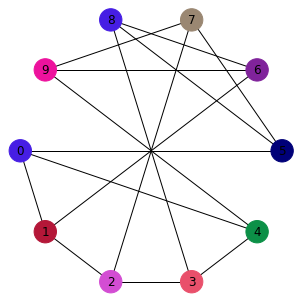

In [30]:
G = nx.petersen_graph()

draw(G, "lightblue", "black",  nx.shell_layout(G))

solutions_peterson = {}
## solve the problem for the petersen graph, and for each k ranging from the chromatich number to n

for k_size in range(gp.chromatic_number(G), len(G.nodes)):
    
    print((' \033[1m' + " k size "+str(k_size) + '\033[0m ').center(150, '='))
    
    color_map, sol = balance_coloring_solver(G, k_size)
    
    draw_sol(G, color_map, nx.shell_layout(G))
    solutions_peterson[k_size] = sol

In [31]:
for k in solutions_peterson:
    print("k", k, " -> sol", solutions_peterson[k]) #for each k contains the value of the z(G, k)

k 3  -> sol 1.0
k 4  -> sol 1.0
k 5  -> sol 0.0
k 6  -> sol 1.0
k 7  -> sol 1.0
k 8  -> sol 1.0
k 9  -> sol 1.0


# **Q5**
Propose a method to find a coloring π such that B(G, π) ≤ 2 and the number k of colors is minimized. Test your method on some random graphs

## **Q5** - Balanced Coloring ILP model

The procedure implemented is to add the constraint $\alpha - \beta >= 2$ to the ILP, then trying to solve the problem with $ k=X(G)$ and, if there's no solution, just increment $k$ and try again.

In [32]:
# same function as begfore but with an exrta constraint to keep the alpha-beta difference >= 2
def balance_coloring_solver1(G, k_size):
    
    C = [k for k in range(k_size)]
    # Build our Model
    balanced_coloring = gb.Model()

    # add Variables
    x = balanced_coloring.addVars(G.nodes(), C, vtype=gb.GRB.BINARY, name='x')
    alpha = balanced_coloring.addVar(vtype=gb.GRB.CONTINUOUS, ub=len(G.nodes()), name='alpha')
    beta = balanced_coloring.addVar(vtype=gb.GRB.CONTINUOUS, lb=0, name='beta')
    
    # add Objective
    balanced_coloring.setObjective(alpha-beta, gb.GRB.MINIMIZE)

    balanced_coloring.addConstr(k_size<=len(G.nodes()))

    # Constraints
    for c in C:
        # alpha-beta constraints
        balanced_coloring.addConstr(alpha >= gb.quicksum(x[i,c] for i in G.nodes()), 'max_alpha_'+str(c))
        balanced_coloring.addConstr(beta <= gb.quicksum(x[i,c] for i in G.nodes()), 'min_beta_'+str(c))

        # coloring constraints
        for i,j in G.edges():
            balanced_coloring.addConstr(x[i,c] + x[j,c] <= 1, 'coloring_'+str(c)+'_('+str(i)+','+str(j)+')')

        # color usage constraints
        balanced_coloring.addConstr(gb.quicksum(x[i,c] for i in G.nodes())>=1, 'color_usage'+str(c))

    for i in G.nodes():
        balanced_coloring.addConstr(gb.quicksum(x[i,c] for c in C) == 1, 'one_color_'+str(i))
    
    # new constraint
    balanced_coloring.addConstr(alpha - beta <= 2, 'alpha_min_beta')

    balanced_coloring.update()
    balanced_coloring.optimize()
    
    
    print("The optimal value is ", balanced_coloring.objVal)
    
    color_map = []
    palette = ['#%06X' % random.randint(0, 0xFFFFFF) for i in G.nodes()]
    for i in G.nodes():
        for c in range(k_size):
            if(x[i,c].x > 1E-3):
                color_map.append(palette[c])
                
    return color_map, balanced_coloring.objVal

The following graph has been chosen as example because, even if it's chromatic number is 2, with k=2 the added constraint is violated, so k is incremented and solved  

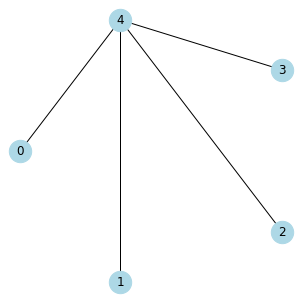

=================================================================  k size 2 ==================================================================
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 21 rows, 12 columns and 62 nonzeros
Model fingerprint: 0xad08223c
Variable types: 2 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 16 rows and 11 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -

 
 ================> Violated the alpha-beta<=2 constraint <================> 
 

=================================================================  k size 3 ======

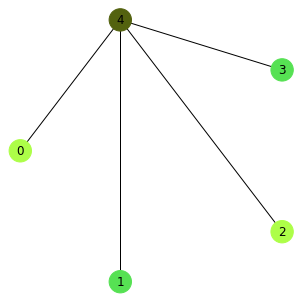

In [35]:
################## Build The Graph ##################
G = nx.Graph()
G.add_nodes_from([0,1,2,3,4])
G.add_edges_from([(0, 4), (1, 4), (2, 4), (3, 4)])

draw(G, "lightblue", "black",  nx.shell_layout(G))

k_size = gp.chromatic_number(G)

sol_found=False

while(sol_found != True):
    
    print((' \033[1m' + " k size "+str(k_size) + '\033[0m ').center(150, '='))

    try:
        color_map, sol = balance_coloring_solver1(G, k_size)
        sol_found=True
    except:
        print("\n \n ================> Violated the alpha-beta<=2 constraint <================> \n \n")
        k_size += 1
        
draw_sol(G, color_map,  nx.shell_layout(G))